In [ ]:
!pip install transformers[torch] -q
!pip install accelerate -U -q
!pip install datasets[audio] -q
!pip install evaluate -q
!pip install jiwer -q
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.1 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
import accelerate
import transformers
from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import WhisperProcessor
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from datasets import Audio
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

In [30]:
import numpy as np
import IPython.display as ipd
from IPython.display import HTML
import torch
import transformers
import datasets
import librosa
import re
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import evaluate
import nltk
import librosa.display

#only use german data due to resource

In [ ]:
data_minds14 = DatasetDict()

data_minds14["train"] = load_dataset(
    "PolyAI/minds14", "de-DE", split="train"
)


Generating train split:   0%|          | 0/611 [00:00<?, ? examples/s]

In [ ]:
train_test_split = data_minds14["train"].train_test_split(test_size=0.2)

# The result is a new DatasetDict with train and test splits
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 488
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 123
    })
})

In [26]:
dataset_dict['train'].features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [ ]:
dataset_dict['train'][0]

{'path': '/storage/hf-datasets-cache/all/datasets/64716162530215-config-parquet-and-info-PolyAI-minds14-1c7e5bf2/downloads/extracted/7c3a41851a7179754414008da875cdd27ade37899d6ca07f613e2d554166234a/de-DE~BUSINESS_LOAN/response_11.wav',
 'audio': {'path': 'response_11.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ...,  0.00024414,
         -0.00024414, -0.00146484]),
  'sampling_rate': 8000},
 'transcription': 'ja doch ich habe davon Spar angerufen aber jetzt beruhigt man noch mal wegen einem Kredit ich habe eine neue Frage wegen dem Bestehen nicht Editon den neuen kriege ich machen will in die können wir das verbinden können',
 'english_transcription': 'yes, I called Spar about it, but now you calm down again because of a loan I have a new question because of the not existing editon get the new one I want to do in the can we can combine that',
 'intent_class': 5,
 'lang_id': 1}

Intention Distribution


In [ ]:
intent_classes = [
    {'index': 0, 'name': 'abroad'},
    {'index': 1, 'name': 'adress'},
    {'index': 2, 'name': 'app_error'},
    {'index': 3, 'name': 'atm_limit'},
    {'index': 4, 'name': 'balance'},
    {'index': 5, 'name': 'business_loan'},
    {'index': 6, 'name': 'card_issues'},
    {'index': 7, 'name': 'cash_deposite'},
    {'index': 8, 'name': 'direct_debit'},
    {'index': 9, 'name': 'freeze'},
    {'index': 10, 'name': 'latest_transactions'},
    {'index': 11, 'name': 'joint_account'},
    {'index': 12, 'name': 'high_value_payment'},
    {'index': 13, 'name': 'pay_bill'}
]

def plot_label_distribution(dataset):
    # Extract intent_class labels
    labels = dataset['intent_class']

    # Count the frequency of each label
    label_counts = {}
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Sort labels by their counts in descending order
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels = [{'name': intent_classes[label[0]]['name'], 'index': intent_classes[label[0]]['index'], 'count': label[1]} for label in sorted_labels]

    # Create x-axis labels combining name and index
    x_labels = [f"{label['name']} ({label['index']})" for label in sorted_labels]
    counts = [label['count'] for label in sorted_labels]

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(x_labels, counts, color='green')
    plt.xlabel('Intent Class')
    plt.ylabel('Frequency')
    plt.title('Distribution of Intent Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

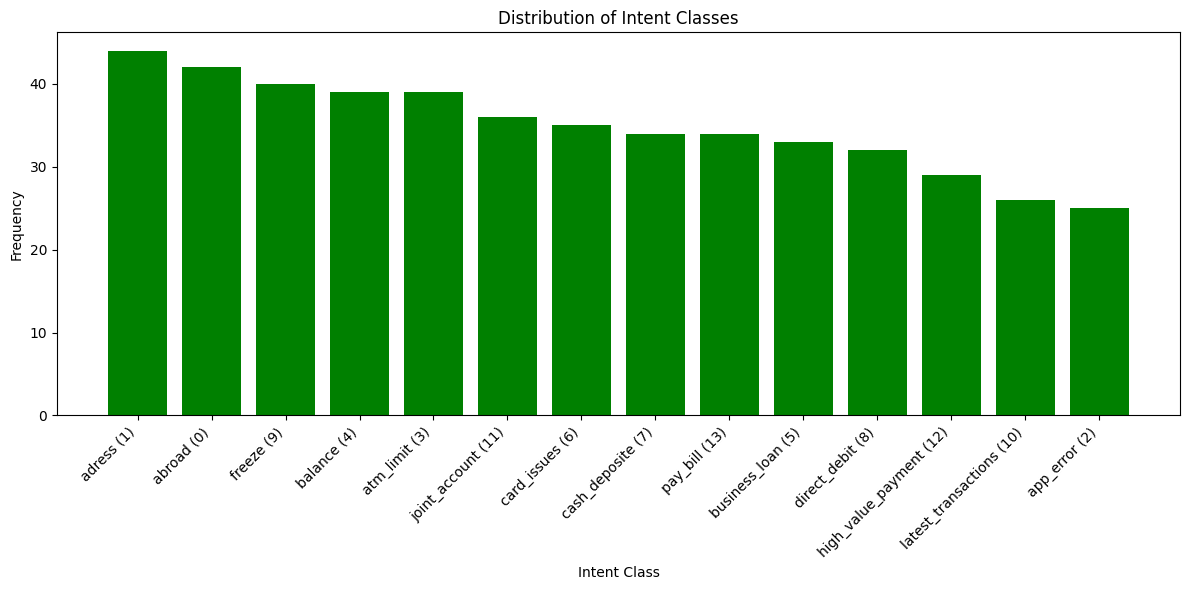

In [ ]:
plot_label_distribution(dataset_dict['train'])

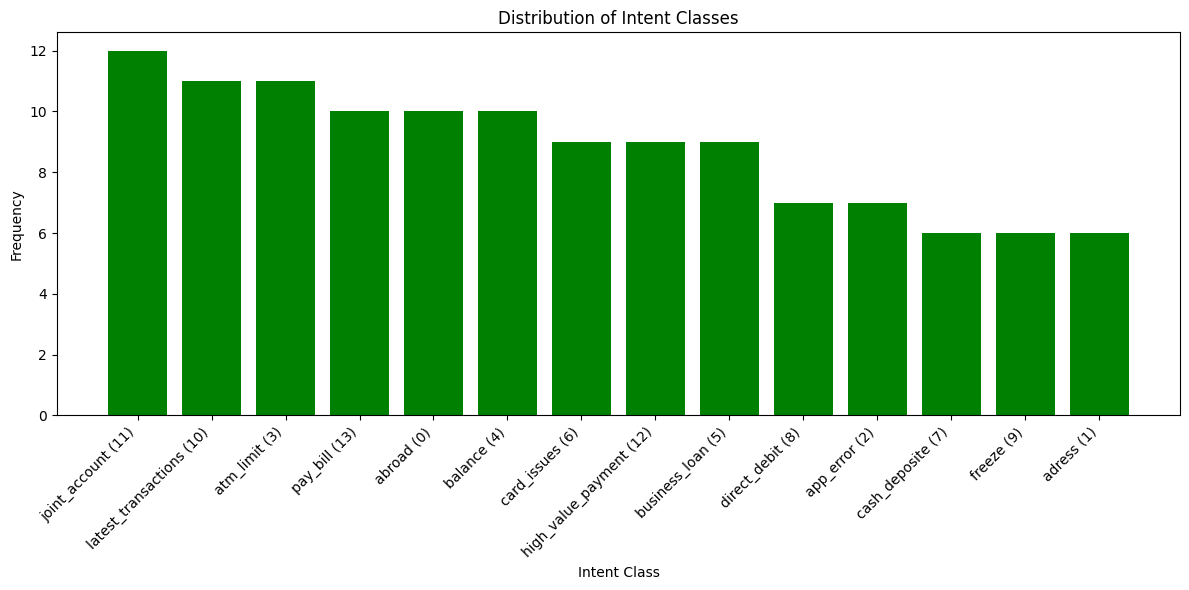

In [ ]:
plot_label_distribution(dataset_dict['test'])

Visualize spectogram for each intent class

In [ ]:
import IPython.display as ipd
from IPython.core.display import display

def plot_waveform_and_spectrogram(dataset, intent_class, name_intent):
    # Filter dataset for a specific intent_class
    filtered_data = dataset.filter(lambda example: example['intent_class'] == intent_class)

    # Take the first audio sample for the given intent_class
    sample = filtered_data[0]

    # Extract audio array and sampling rate
    audio_array = sample['audio']['array']
    sr = sample['audio']['sampling_rate']

    # display(Audio(sample['audio']))
    ipd.Audio(data=np.asarray(sample['audio']['array']), rate=8000)

    print("transcription: ", sample['transcription'])

    # Plot Waveform
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    librosa.display.waveshow(audio_array, sr=sr)
    plt.title(f'Waveform for intent_class: {intent_class} {name_intent}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Compute and plot Spectrogram
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    X = librosa.stft(audio_array)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram for intent_class: {intent_class} {name_intent}')

    plt.tight_layout()
    plt.show()

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ich habe eine Bankkarte und ich brauche meine Bankkarte im Ausland kann ich mir Sachen bezahlen wenn ich in Amerika bin mit meiner Bank habe gerade


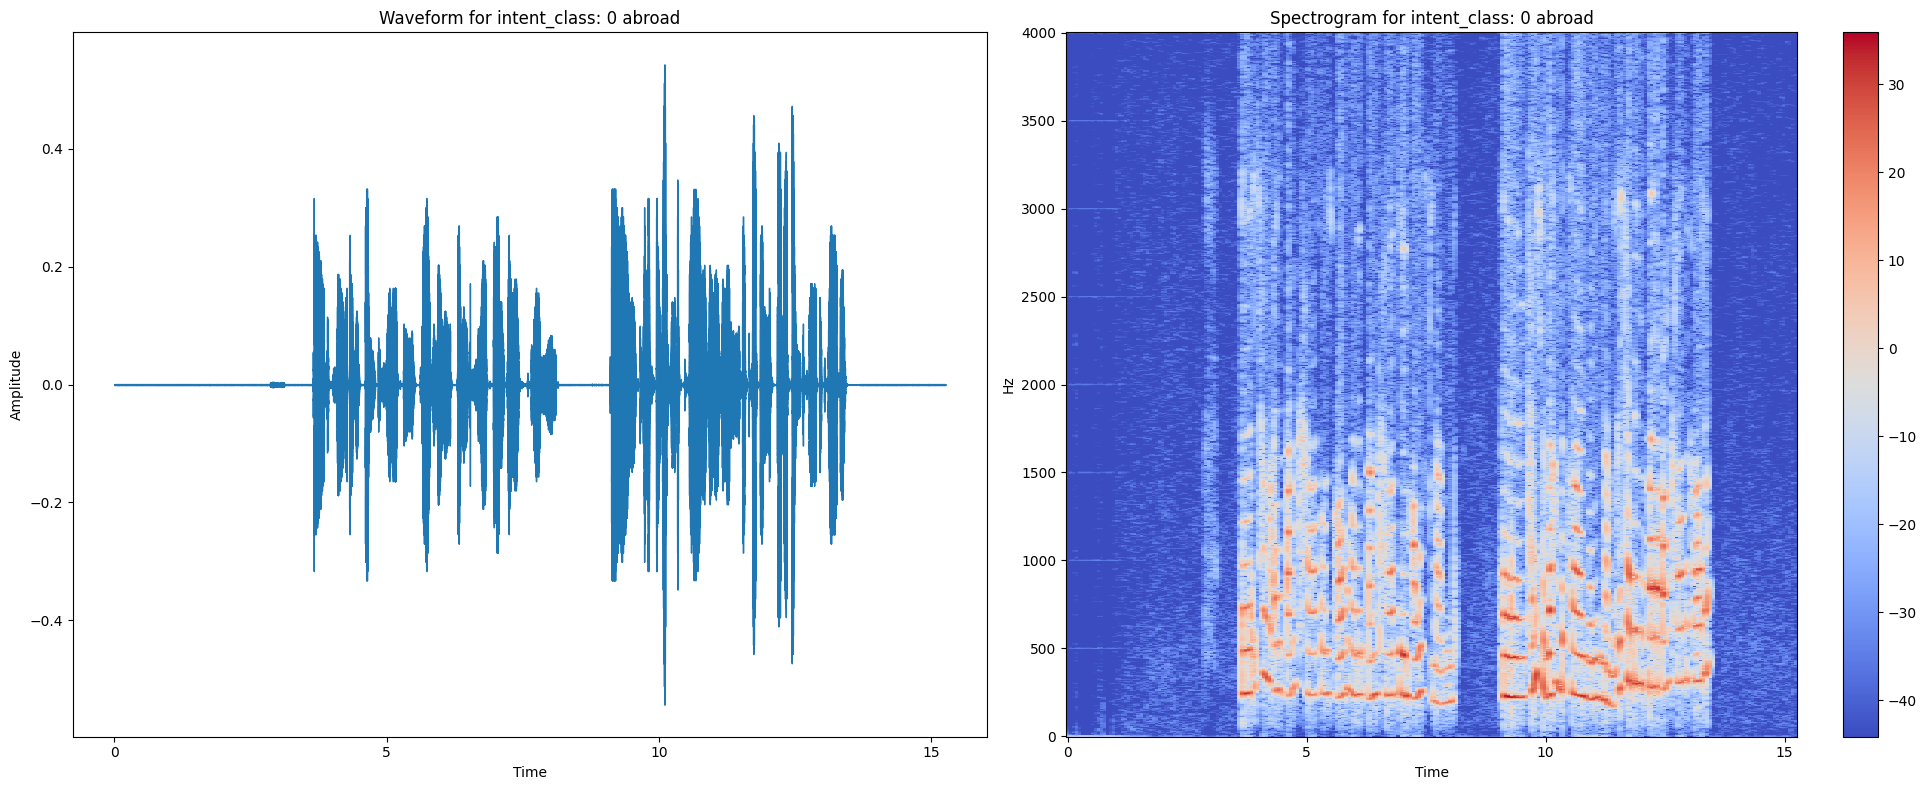

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  guten Tag und zwar ich rufe an weil ich letztens umgezogen bin und gerne bei Ihnen meine Adresse ändern möchte wo kann ich das machen muss ich das online machen oder am Schalter oder wie sind da die Möglichkeiten meine Adresse zu ändern


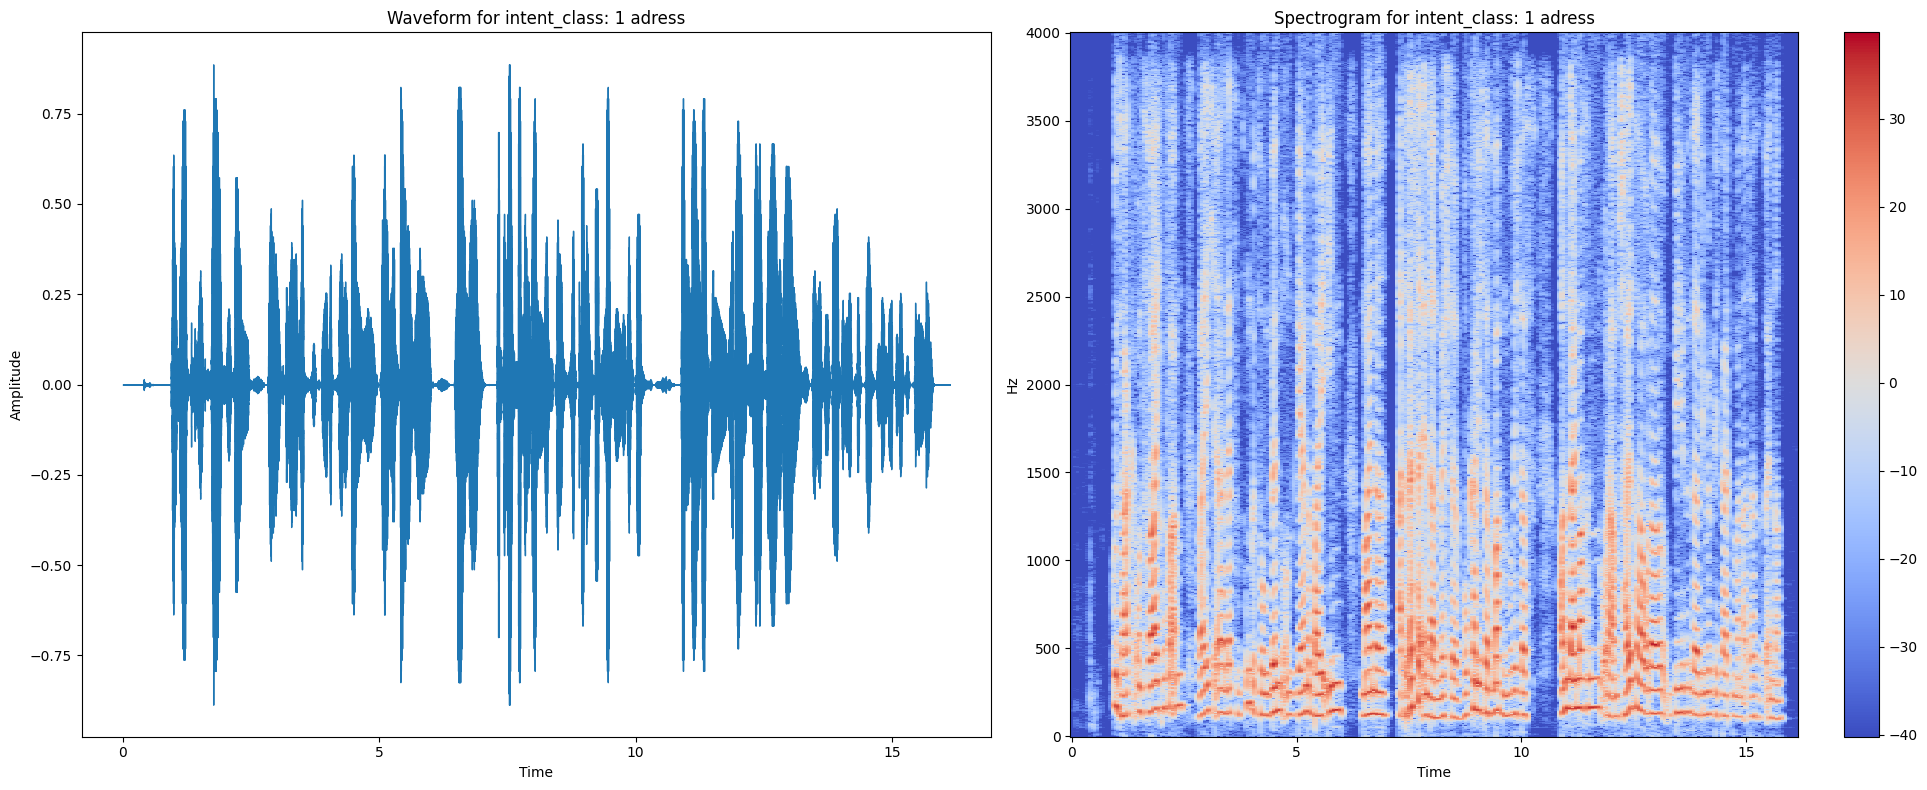

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  die Apps lädt nicht


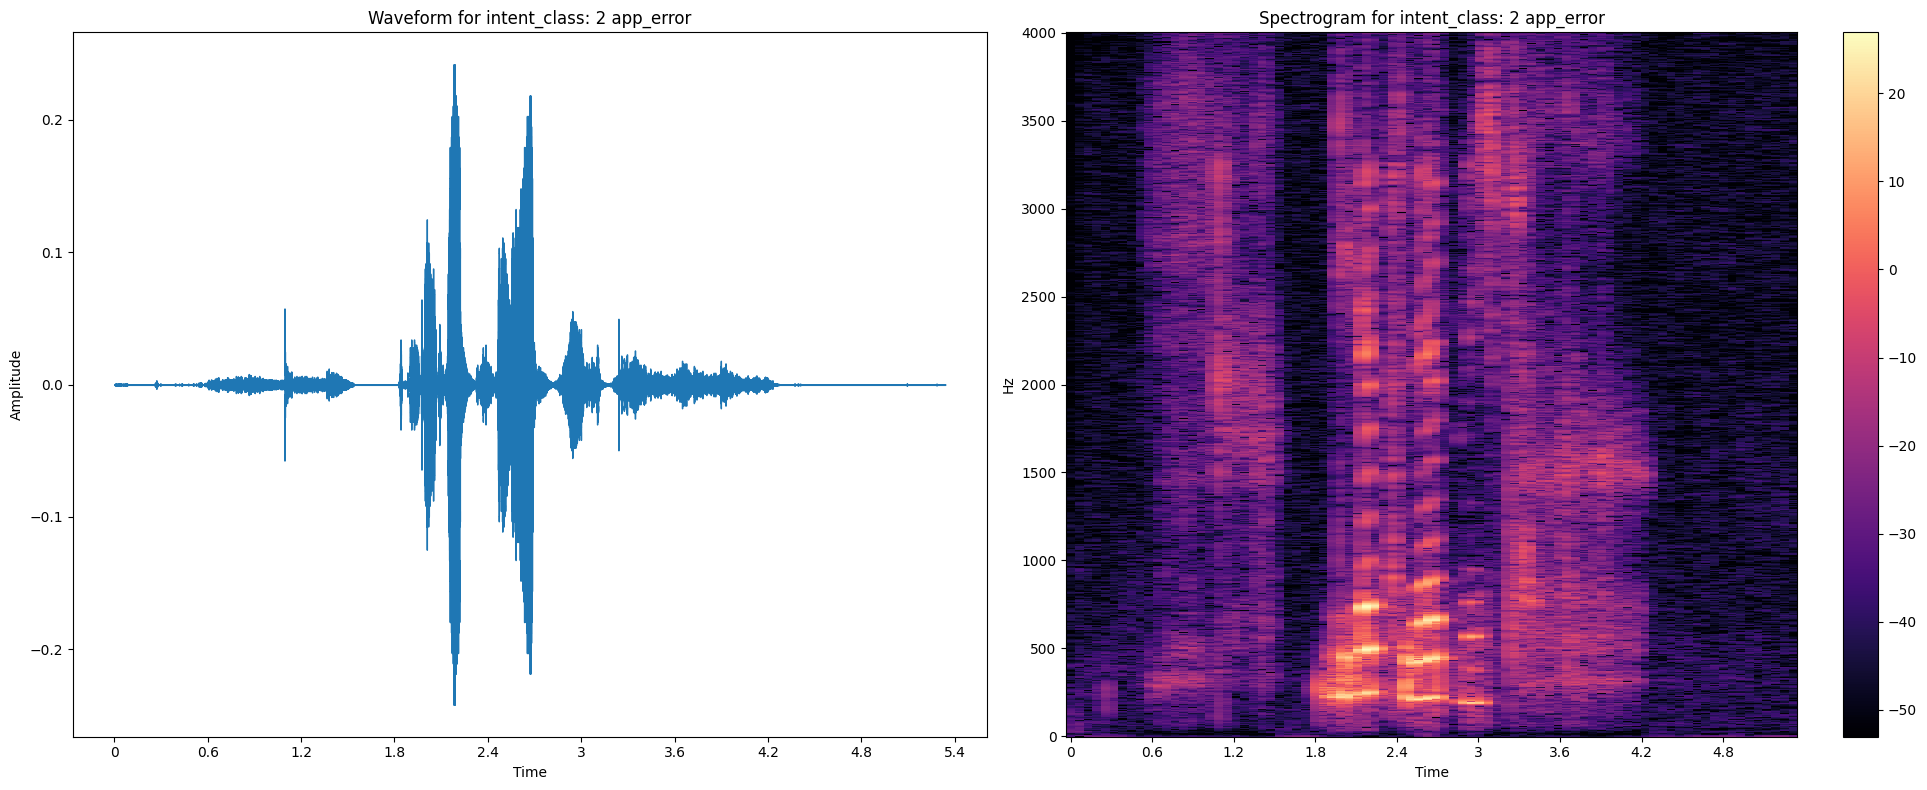

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  Hallo ich würde gerne Geld am Geldautomaten abheben und ich würde gerne wissen wie viel Geld ich da maximal abheben kann


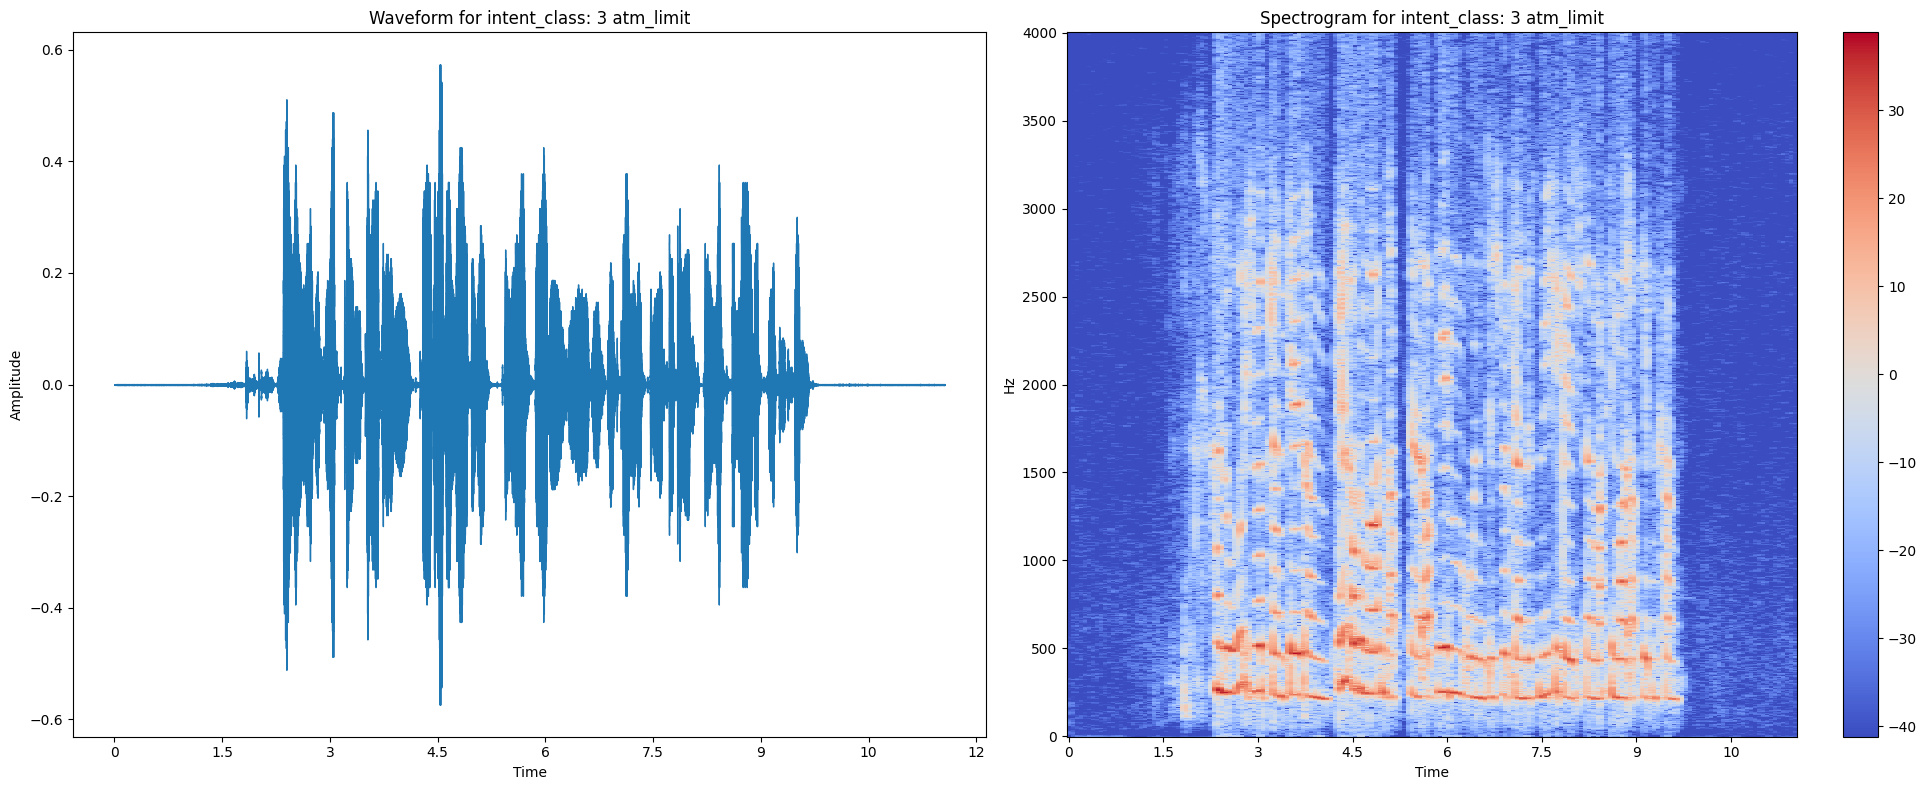

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ich möchte herausfinden wie viel Geld auf meinem Konto ist


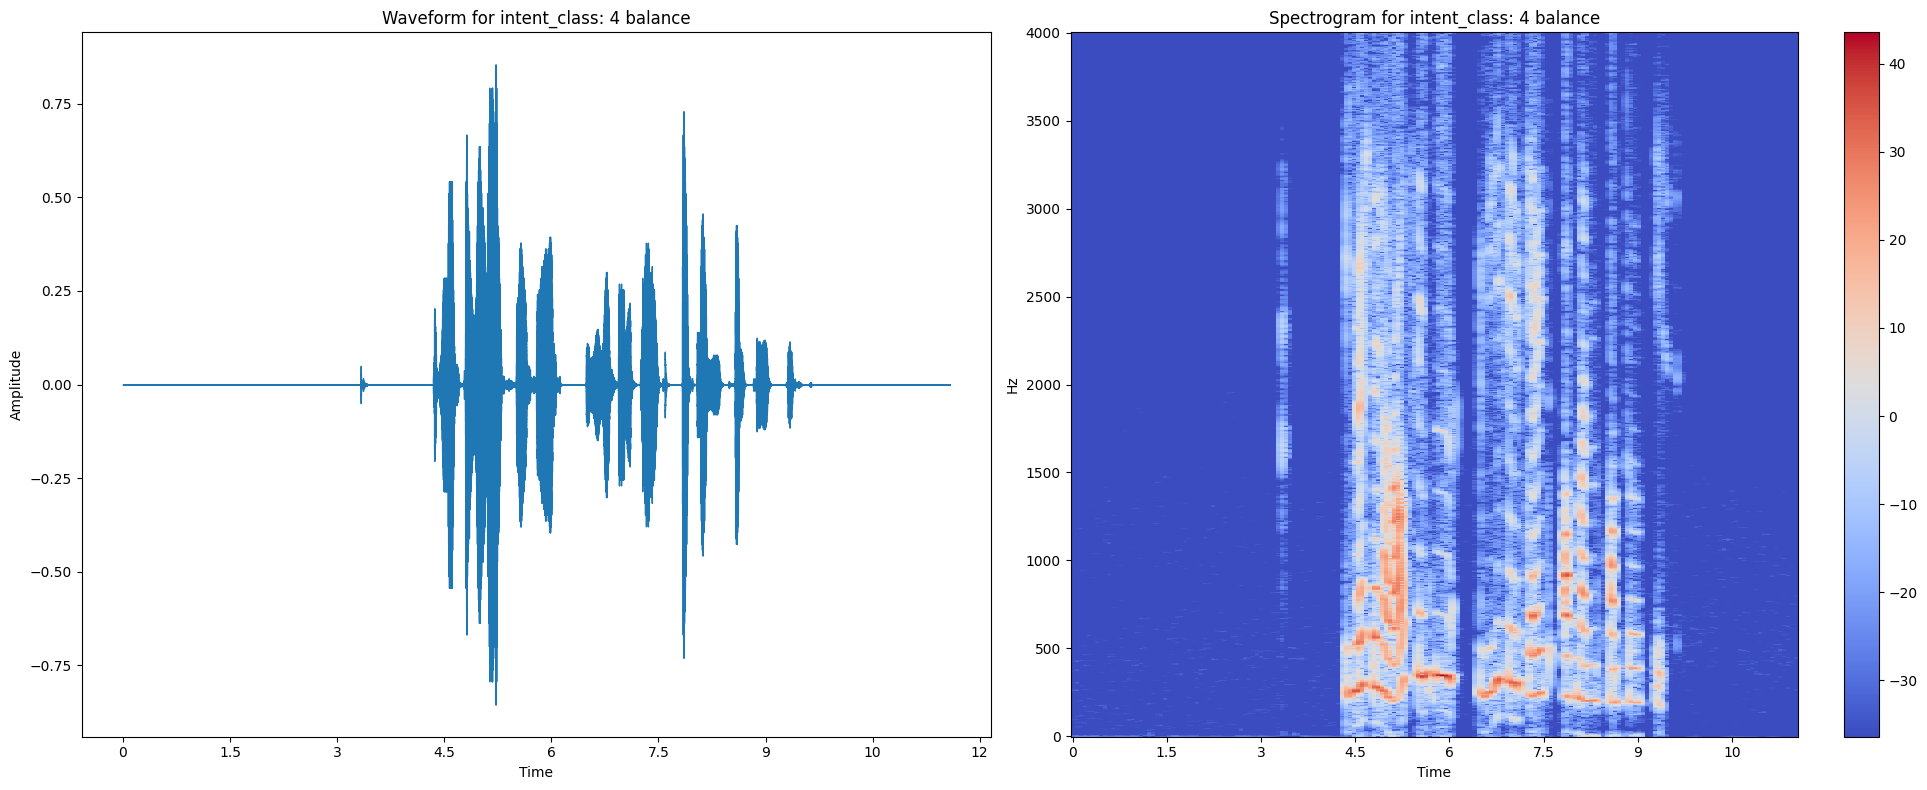

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ja doch ich habe davon Spar angerufen aber jetzt beruhigt man noch mal wegen einem Kredit ich habe eine neue Frage wegen dem Bestehen nicht Editon den neuen kriege ich machen will in die können wir das verbinden können


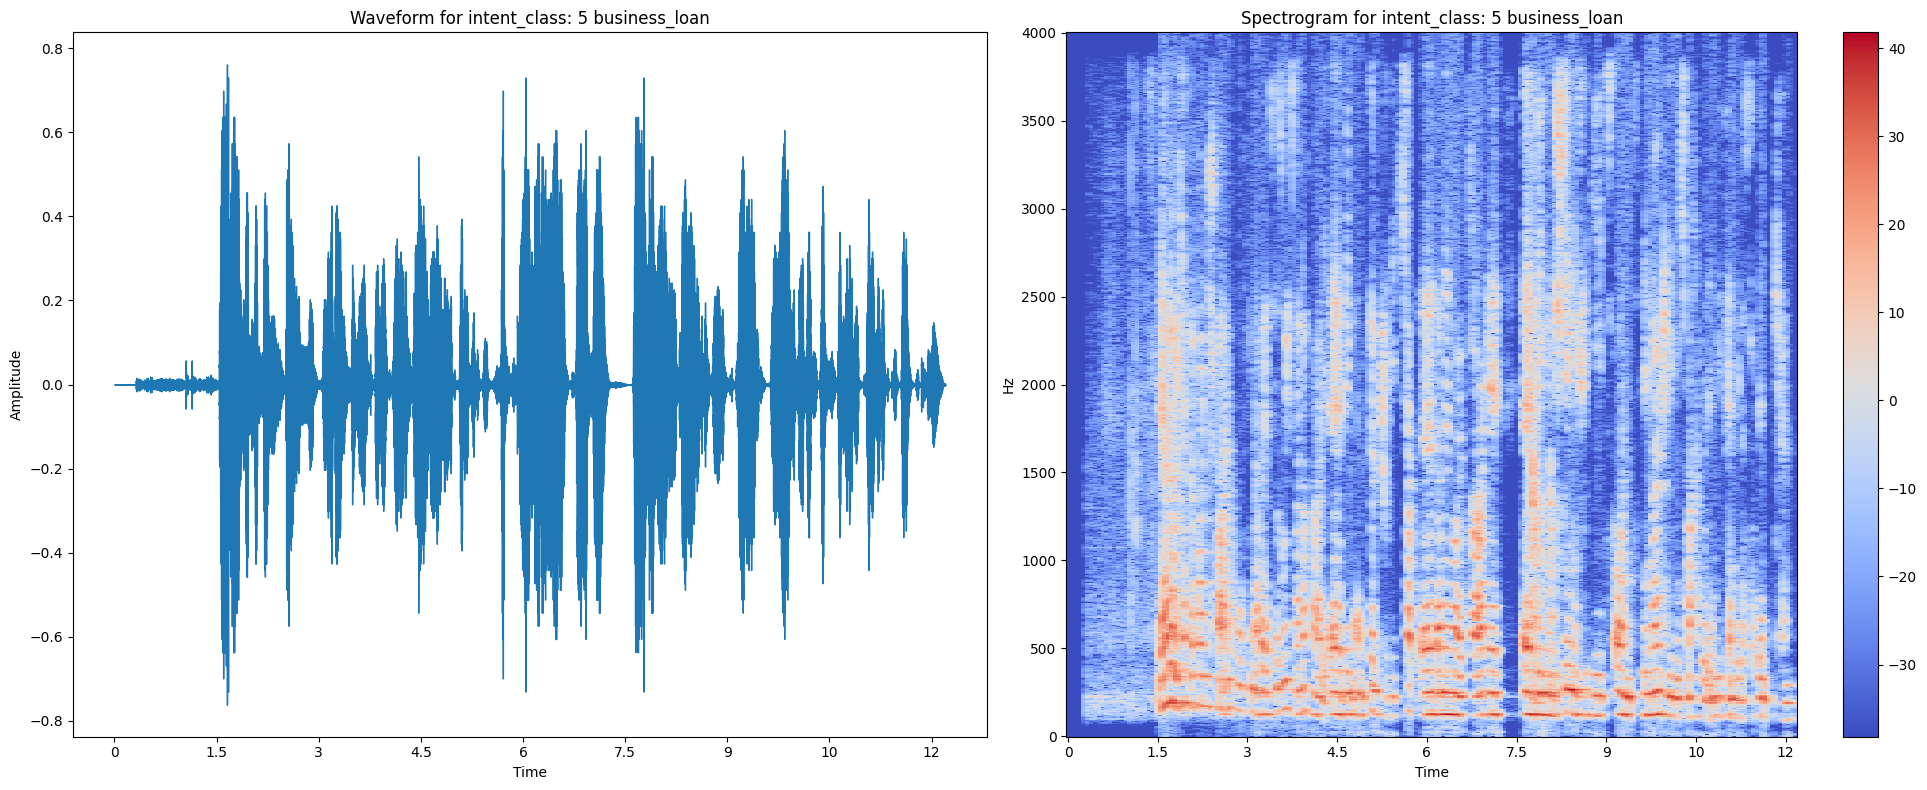

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  alle meine Bankomatkarte funktioniert mit Jürgen wissen warum und warum die Bezahlung abgelehnt worden ist


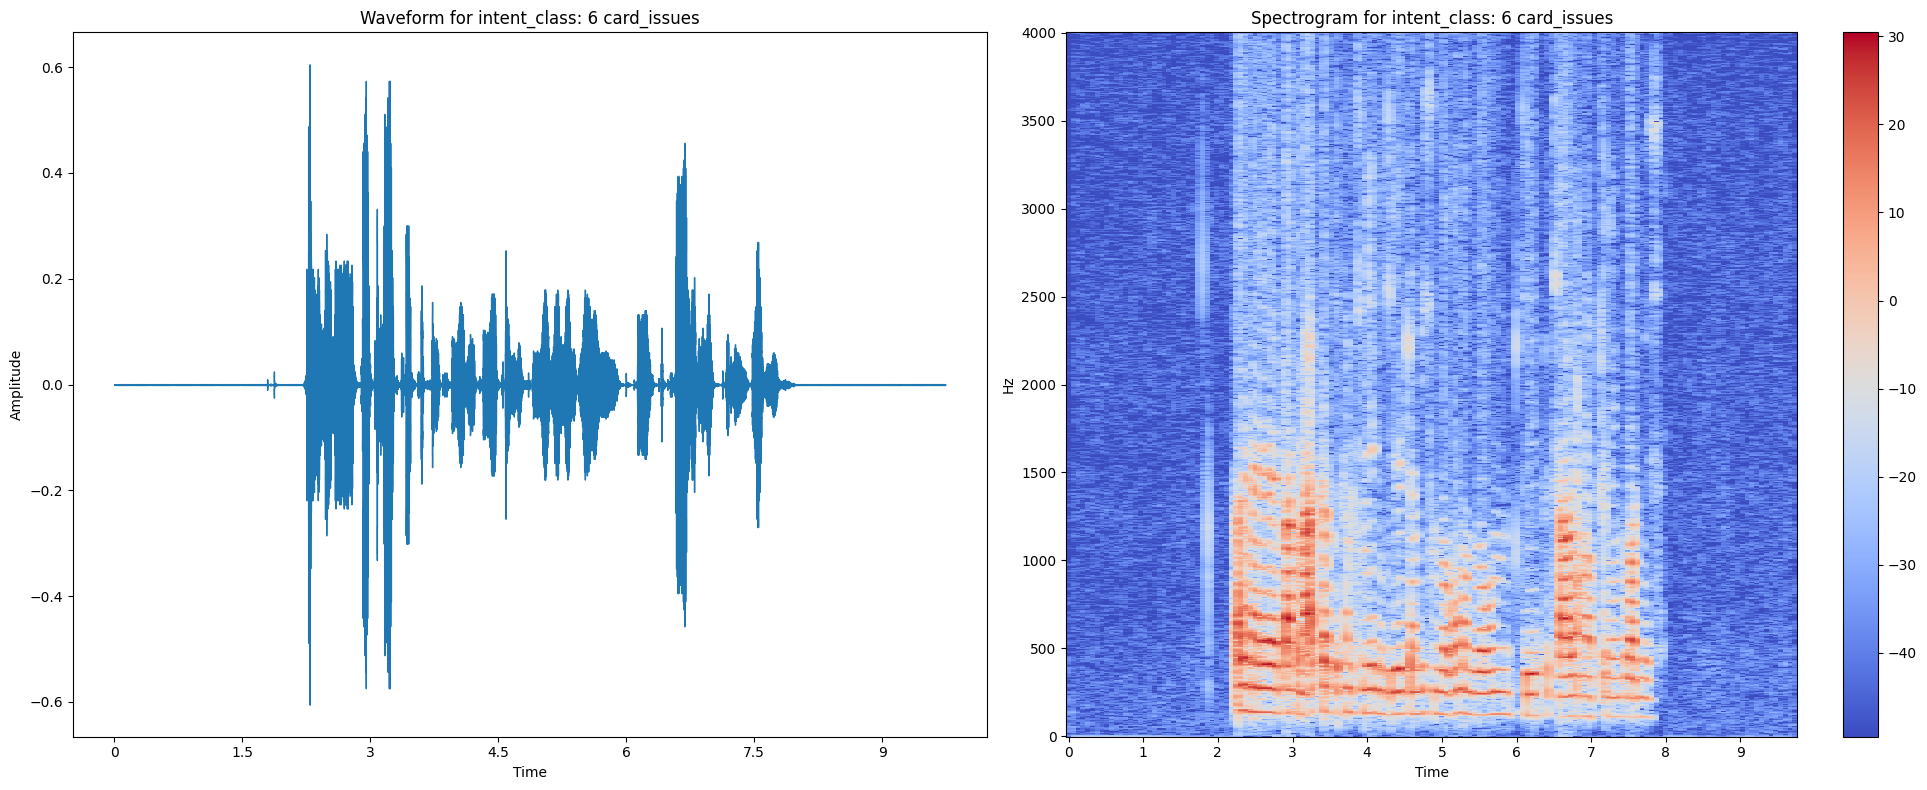

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ja hallo guten Nachmittag ich wollte fragen ob ich auf meinem Konto Geld einzahlen kann ob das möglich ist können Sie mir dabei weiterhelfen danke schön


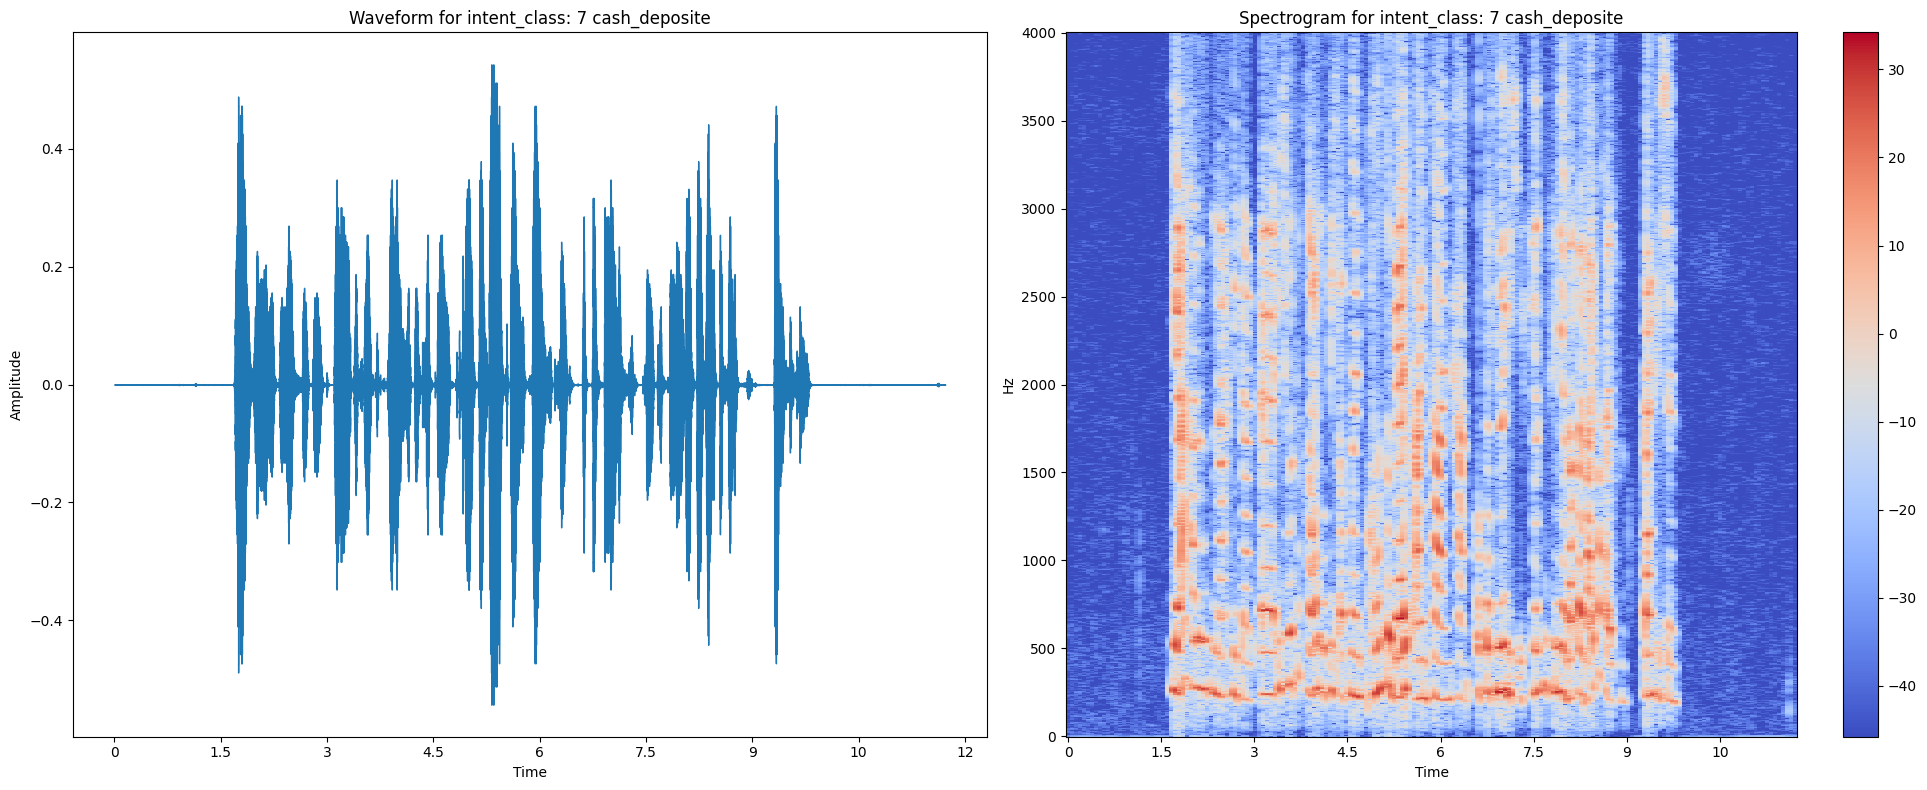

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  hallo ich hätte eine Frage bezüglich Lastschriften und zwar geht es um folgendes dass ich online etwas bestellt habe und per Lastschrift bezahlt habe das aber nur noch rückgängig machen würde gerne könnten Sie mir da weiterhelfen


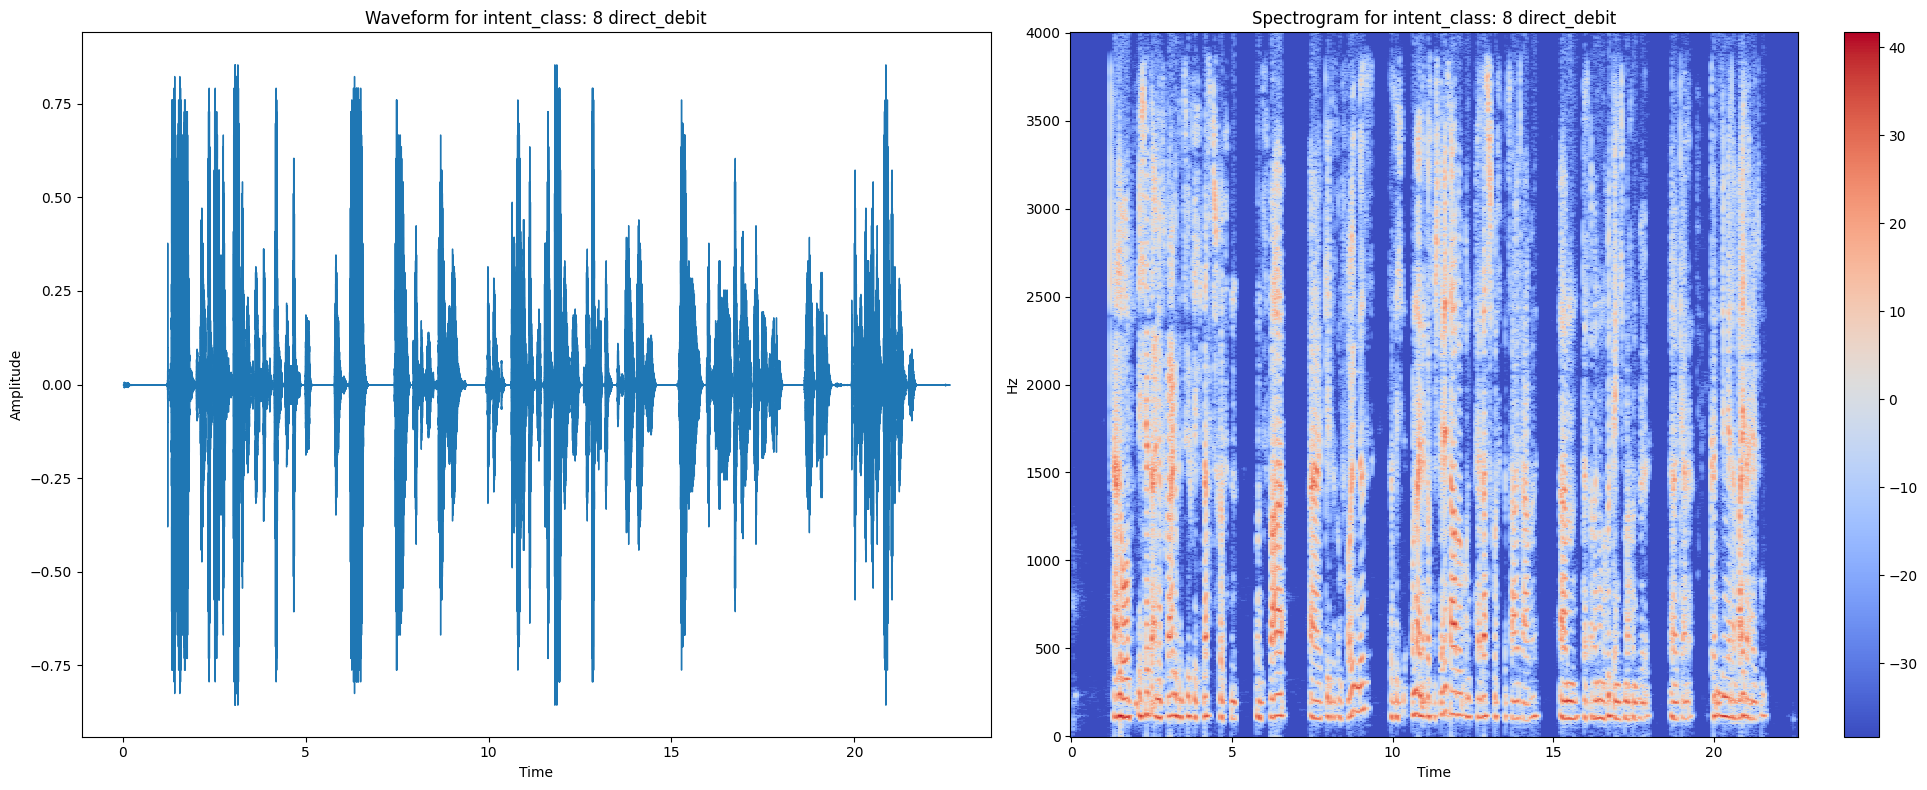

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ich würde gerne meinen Karte sperren lassen


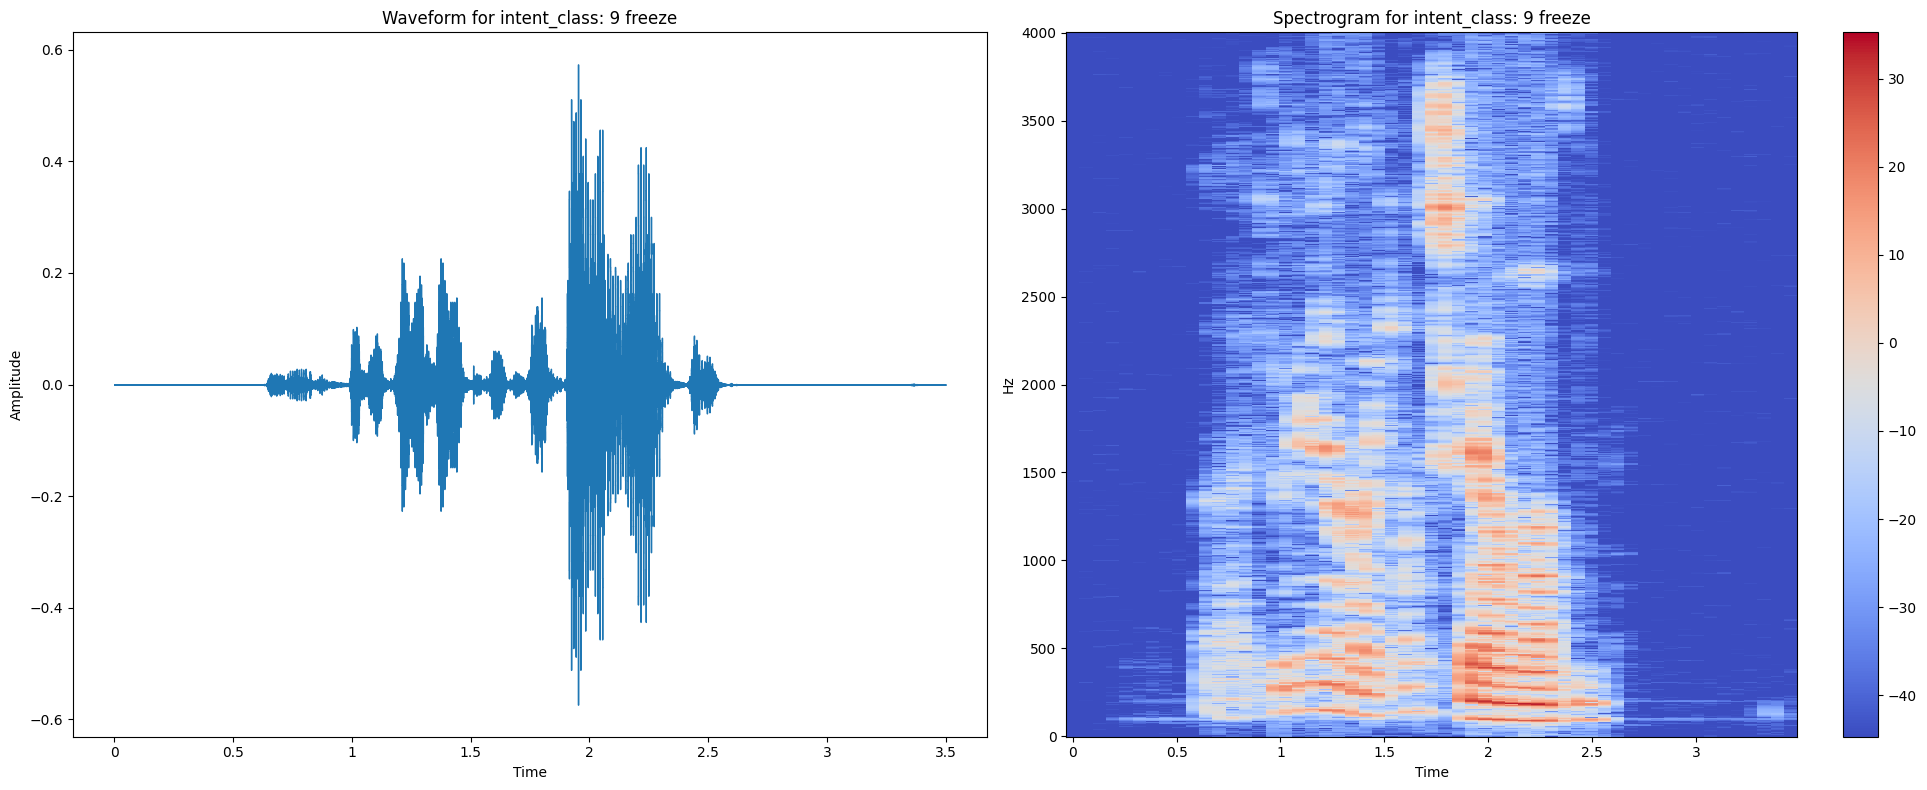

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  guten Tag ich möchte gerne einen teuren Artikel bezahlen


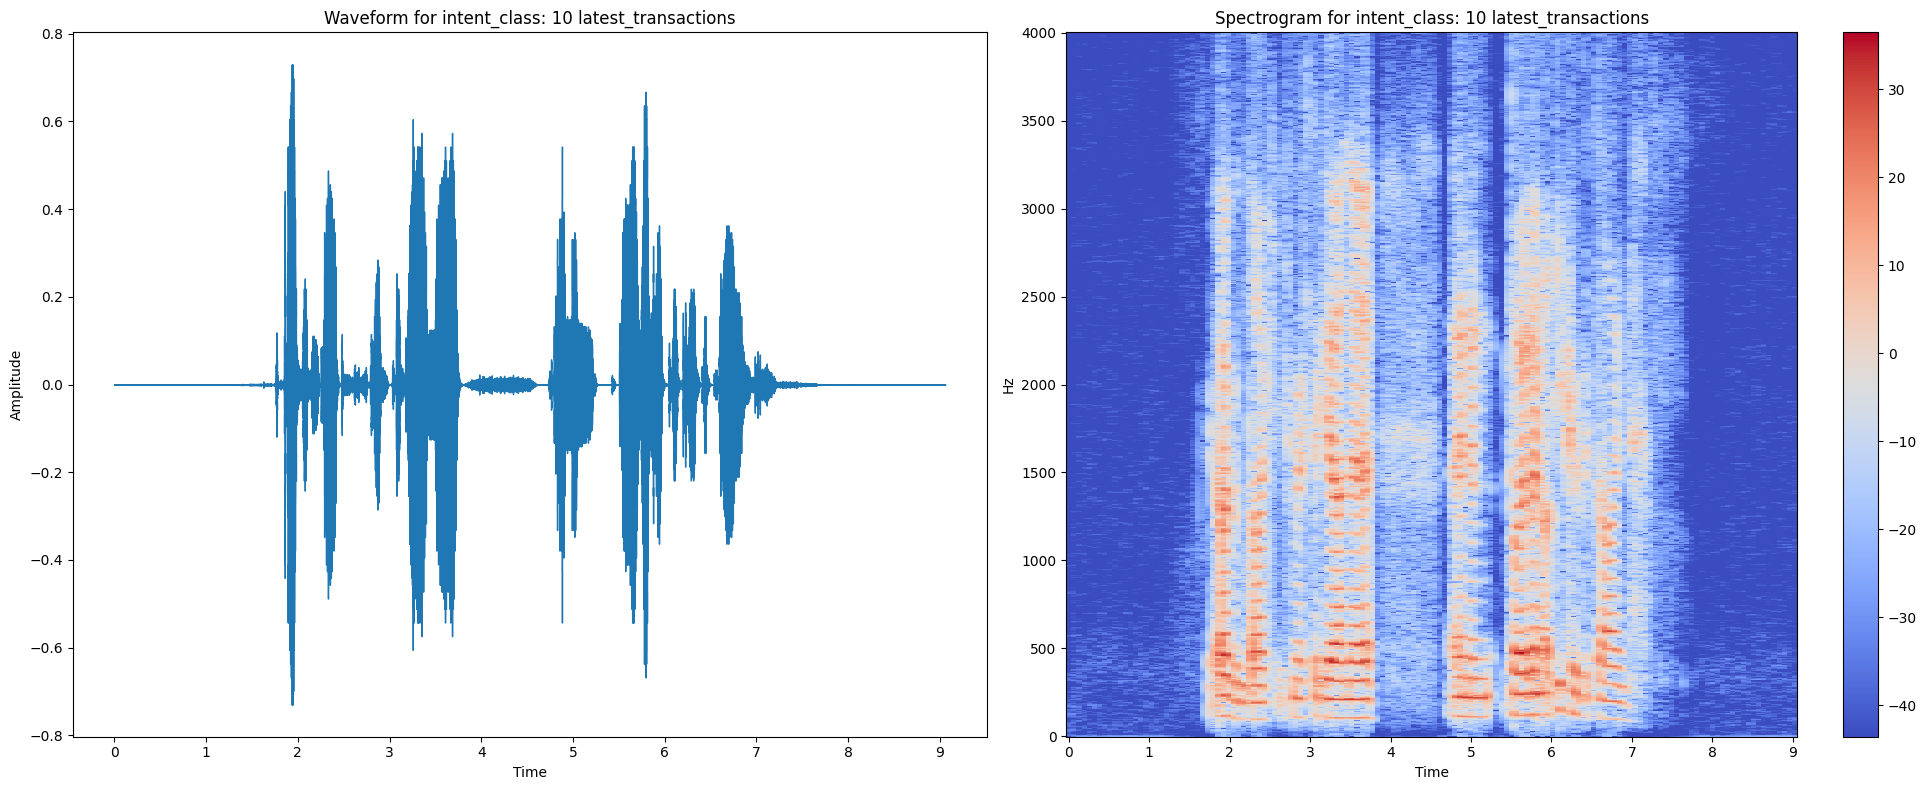

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  Doris Meyer ich möchte ein Gemeinschaftskonto einrichten um bitte hierzu um nähere Informationen per E-Mail vielen Dank vorab


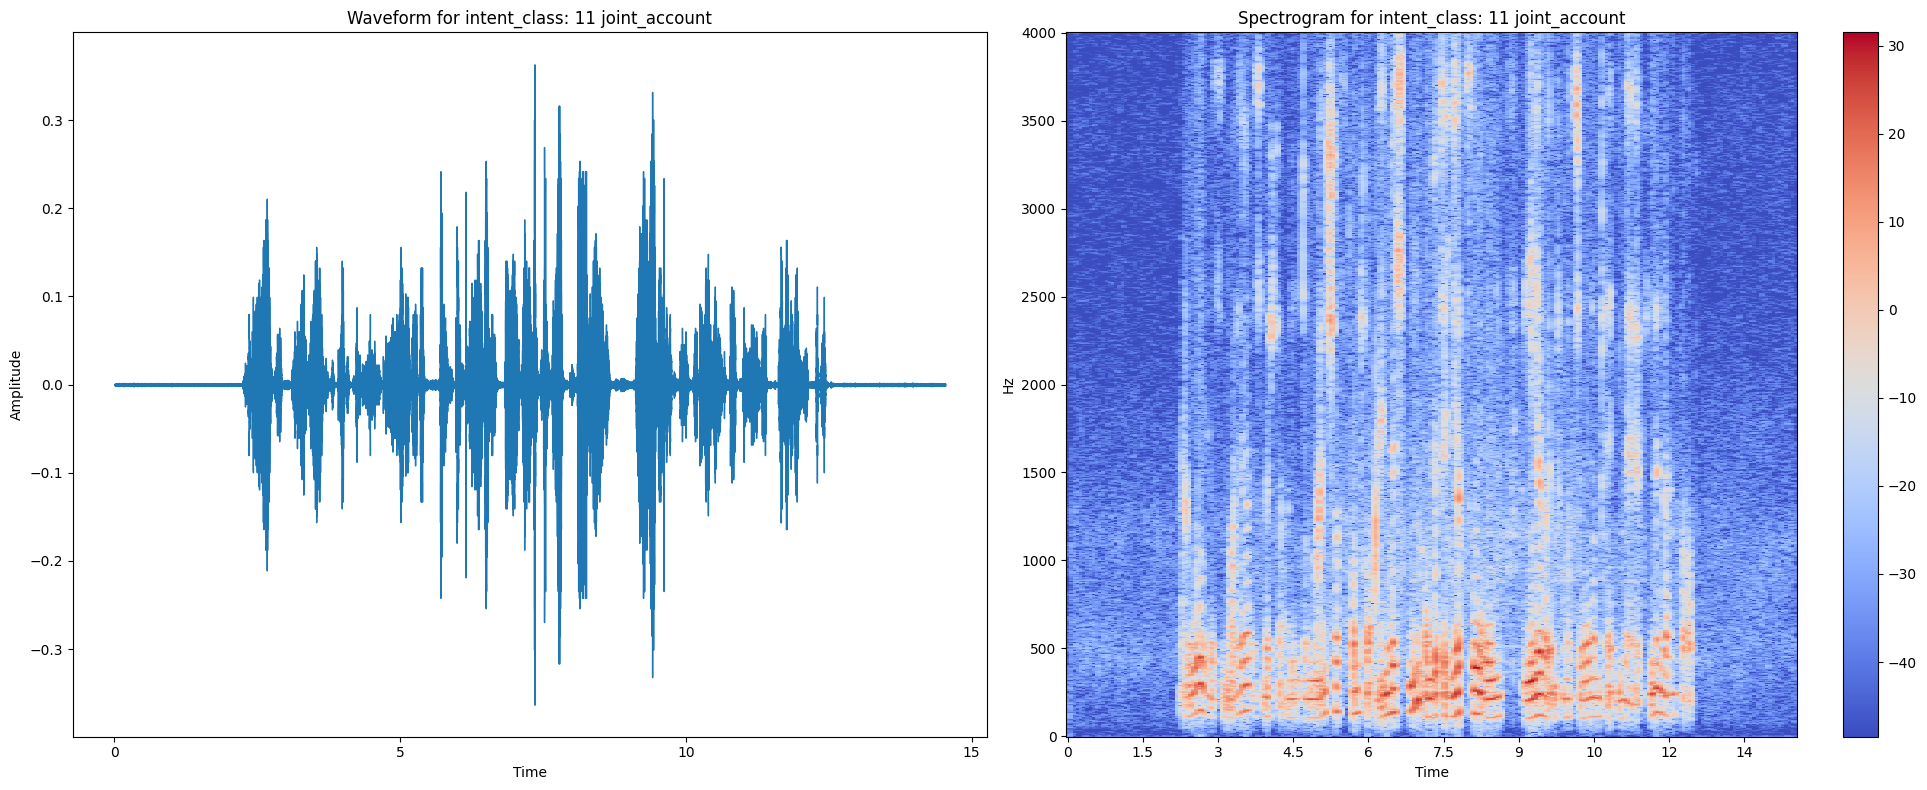

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  ja schönen guten Tag ich habe ein Bankkonto bei Ihnen und ich möchte mir gerne die neuesten Transaktionen anzeigen lassen


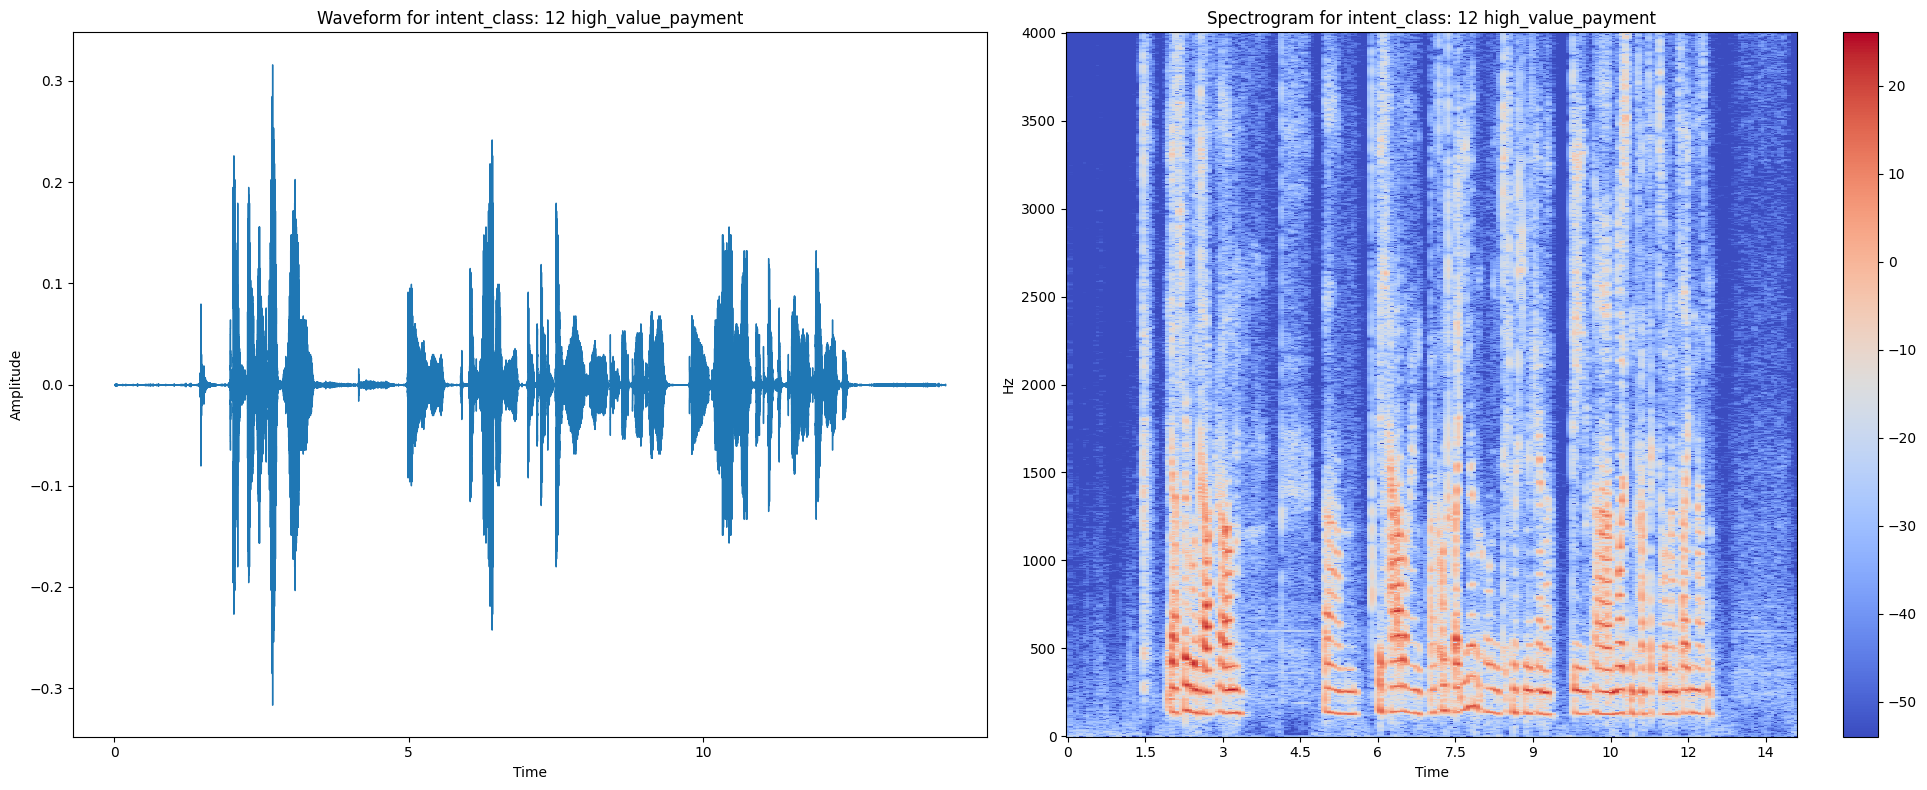

Filter:   0%|          | 0/488 [00:00<?, ? examples/s]

transcription:  Hallo ich würde gerne eine Rechnung bezahlen und eine Zahlung tätigen ich nicht aufmachen


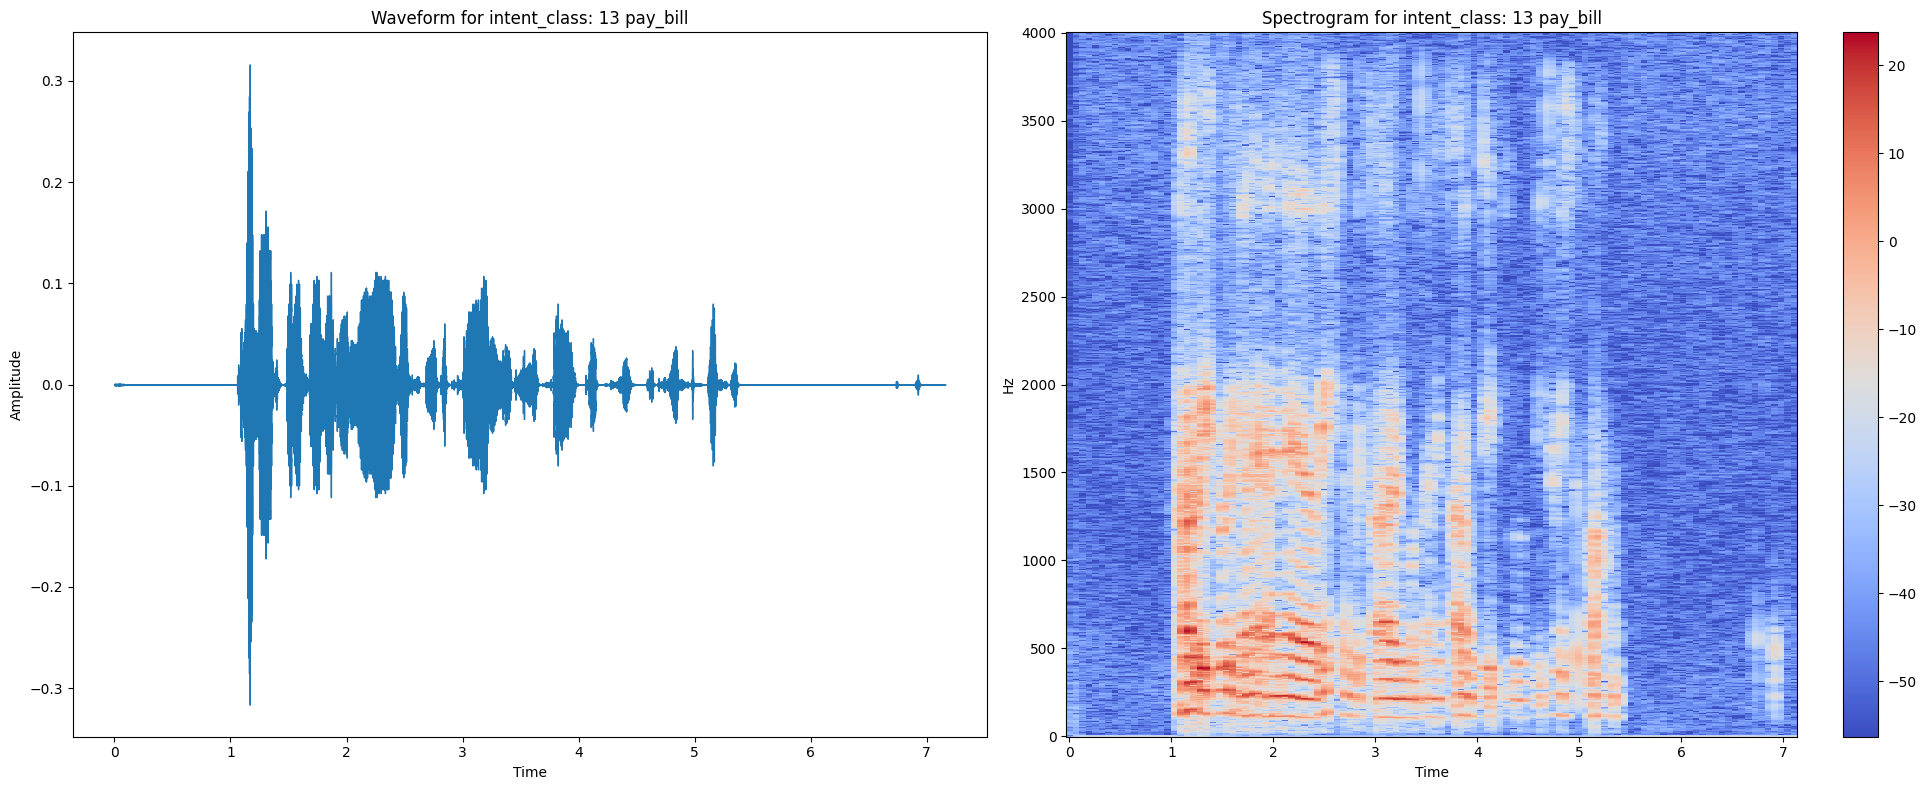

In [ ]:
for intent in range(len(intent_classes)):
  # print(intent)
  # print(intent_classes[intent]['name'])
  plot_waveform_and_spectrogram(dataset_dict['train'], intent, intent_classes[intent]['name'])

In [28]:
#check null values
def count_feature_lengths(dataset):
    feature_lengths = {}

    for feature in dataset.features:
        values = dataset[feature]
        lengths = [len(str(value)) if not isinstance(value, (int, float, dict, list)) else 1 for value in values]
        feature_lengths[feature] = lengths
    return feature_lengths

# Count the lengths and store them
feature_lengths = count_feature_lengths(dataset_dict['train'])

# Print the lengths for each feature
for feature, lengths in feature_lengths.items():
    print(f"{feature}: {len(lengths)}")

path: 488
audio: 488
transcription: 488
english_transcription: 488
intent_class: 488
lang_id: 488


In [31]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))


show_random_elements(dataset=dataset_dict['train'].remove_columns(['audio', 'path']), num_examples=10)

In [32]:
dataset_dict["train"].features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [33]:
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="german", task="transcribe"
)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

In [34]:
#change sampling rate to 16k
from datasets import Audio

sampling_rate = processor.feature_extractor.sampling_rate
dataset_dict = dataset_dict.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [38]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["transcription"],
    )

    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    return example

In [39]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 488
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 123
    })
})

In [40]:
dataset_dict = dataset_dict.map(
    prepare_dataset, remove_columns=dataset_dict.column_names["train"], num_proc=1
)

Map:   0%|          | 0/488 [00:00<?, ? examples/s]

Map:   0%|          | 0/123 [00:00<?, ? examples/s]

In [41]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 488
    })
    test: Dataset({
        features: ['input_features', 'labels', 'input_length'],
        num_rows: 123
    })
})

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
dataset_dict.save_to_disk('/content/drive/MyDrive/asr/dataset_dict_de')

Saving the dataset (0/1 shards):   0%|          | 0/488 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/123 [00:00<?, ? examples/s]

In [45]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

import torch
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"][0]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [46]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [47]:
import evaluate

metric = evaluate.load("wer")

In [48]:
normalizer = BasicTextNormalizer()


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # compute orthographic wer
    wer_ortho = 100 * metric.compute(predictions=pred_str, references=label_str)

    # compute normalised WER
    pred_str_norm = [normalizer(pred) for pred in pred_str]
    label_str_norm = [normalizer(label) for label in label_str]
    # filtering step to only evaluate the samples that correspond to non-zero references:
    pred_str_norm = [
        pred_str_norm[i] for i in range(len(pred_str_norm)) if len(label_str_norm[i]) > 0
    ]
    label_str_norm = [
        label_str_norm[i]
        for i in range(len(label_str_norm))
        if len(label_str_norm[i]) > 0
    ]

    wer = 100 * metric.compute(predictions=pred_str_norm, references=label_str_norm)

    return {"wer_ortho": wer_ortho, "wer": wer}

In [49]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.84k [00:00<?, ?B/s]

In [51]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/asr/asr-de",  # name on the HF Hub
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    #lr_scheduler_type="constant_with_warmup",
    warmup_steps=50,
    max_steps=500,  # increase to 4000 if you have your own GPU or a Colab paid plan
    gradient_checkpointing=True,
    fp16=True,
    fp16_full_eval=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False
)

In [52]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [53]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=500, training_loss=0.2537909344062209, metrics={'train_runtime': 3115.8469, 'train_samples_per_second': 2.568, 'train_steps_per_second': 0.16, 'total_flos': 2.27174427131904e+18, 'train_loss': 0.2537909344062209, 'epoch': 16.13})

In [54]:
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

In [56]:
from transformers import pipeline
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model_id = "/content/drive/MyDrive/asr/asr-de"
pipe = pipeline("automatic-speech-recognition", model=model_id, device=device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [63]:
data_minds14 = DatasetDict()

data_minds14["train"] = load_dataset(
    "PolyAI/minds14", "de-DE", split="train"
)

In [64]:
train_test_split = data_minds14["train"].train_test_split(test_size=0.2)

# The result is a new DatasetDict with train and test splits
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

In [68]:
dataset_dict['test']

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 123
})

In [66]:
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

all_predictions = []

# run streamed inference
for prediction in tqdm(
    pipe(
        KeyDataset(dataset_dict['test'], "audio"),
        max_new_tokens=128,
        generate_kwargs={"task": "transcribe"},
        batch_size=32,
    ),
    total=len(dataset_dict['test']),
):
    all_predictions.append(prediction["text"])

100%|██████████| 123/123 [00:42<00:00,  2.89it/s]


In [69]:
from evaluate import load

wer_metric = load("wer")

wer_ortho = 100 * wer_metric.compute(
    references=dataset_dict['test']["transcription"], predictions=all_predictions
)
wer_ortho

2.631578947368421

In [70]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

normalizer = BasicTextNormalizer()

# compute normalised WER
all_predictions_norm = [normalizer(pred) for pred in all_predictions]
all_references_norm = [normalizer(label) for label in dataset_dict['test']["transcription"]]

# filtering step to only evaluate the samples that correspond to non-zero references
all_predictions_norm = [
    all_predictions_norm[i]
    for i in range(len(all_predictions_norm))
    if len(all_references_norm[i]) > 0
]
all_references_norm = [
    all_references_norm[i]
    for i in range(len(all_references_norm))
    if len(all_references_norm[i]) > 0
]

wer = 100 * wer_metric.compute(
    references=all_references_norm, predictions=all_predictions_norm
)

wer

2.3039611964430073